In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from model.dataset import HSEDatasetFromSP
from model.regressCNN import RegressionPCA
from SMPL.smpl_torch_batch import SMPLModel

from obj_utils.smpl import get_A_pose
from obj_utils.io import save_obj

### Load Silhouette Images

In [2]:
silhouettes_path = './dataset-generation/silhouettes'
subjects = ['00000', '00025', '00061']

images = []
for s in subjects:
    im_f = cv.imread(os.path.join(silhouettes_path, s, 'frontal.png'))
    im_l = cv.imread(os.path.join(silhouettes_path, s, 'lateral.png'))

    images.append([im_f, im_l])

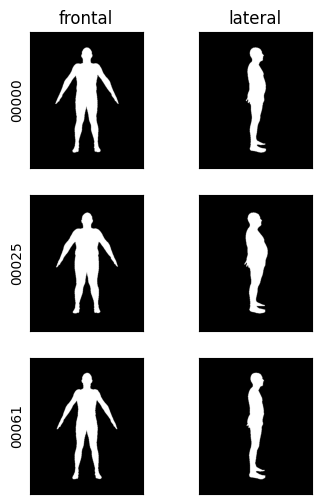

In [3]:
fig, axs = plt.subplots(3, 2, figsize=(4, 6))

for s, im_row, ax_row in zip(subjects, images, axs):
    if s == '00000':
        ax_row[0].set_title('frontal')
        ax_row[1].set_title('lateral')
    
    ax_row[0].set_xticks([])
    ax_row[0].set_yticks([])

    ax_row[1].set_xticks([])
    ax_row[1].set_yticks([])

    ax_row[0].set_ylabel(s)
    ax_row[0].imshow(im_row[0])
    ax_row[1].imshow(im_row[1])

### Extract Sample Points

In [4]:
def get_sample_points(im, sample_num=648):
    im = np.array(im)
    imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

    contours, _ = cv.findContours(imgray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    largest_cont = max(contours, key=cv.contourArea)
    
    num, _, cols = largest_cont.shape
    points = largest_cont.reshape([num, cols])

    head_top_idx = np.argmin(points[:,1])
    points = np.concatenate([points[head_top_idx:], points[head_top_idx:]])

    idx = np.linspace(0, num, sample_num, endpoint=False, dtype=int)
    sample_points = points[idx, :]

    return sample_points

In [5]:
sample_points = []

for s in images:
    sample_points.append(list(map(get_sample_points, s)))

sample_points = np.array(sample_points)

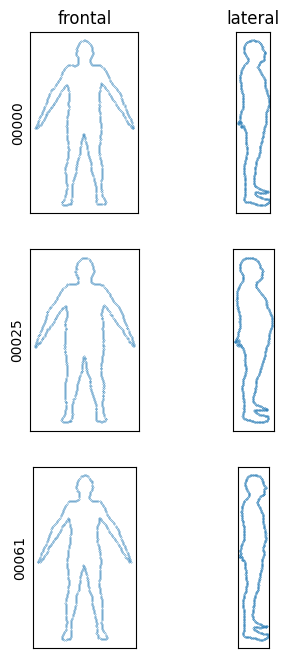

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(4, 8))

for s, sample_row, ax_row in zip(subjects, sample_points, axs):
    if s == '00000':
        ax_row[0].set_title('frontal')
        ax_row[1].set_title('lateral')

    ax_row[0].set_ylabel(s)
    
    ax_row[0].set_xticks([])
    ax_row[0].set_yticks([])
    ax_row[0].set_aspect('equal')

    ax_row[1].set_xticks([])
    ax_row[1].set_yticks([])
    ax_row[1].set_aspect('equal')

    fx, fy = sample_row[0].T
    ax_row[0].scatter(fx, -fy, s=0.05)
    lx, ly = sample_row[1].T
    ax_row[1].scatter(lx, -ly, s=0.05)

### Infer $\hat \beta$

In [7]:
# load model
model_path = './checkpoints/RegressionPCA/epochs_50.ckpt'
model = RegressionPCA(10)
model.load_state_dict(torch.load(model_path))
model.to('cuda')
model.eval()

print('model loaded')

model loaded


In [8]:
hse_dataset = HSEDatasetFromSP(sample_points)
hse_dataloader = DataLoader(hse_dataset, batch_size=1, shuffle=False)

In [19]:
betas = []

with torch.no_grad():
    for f, l in hse_dataloader:
        b = model(f, l).detach().cpu().numpy()
        betas.append(b)

betas = np.array(betas).reshape(-1, 10)

### Make Meshes

In [20]:
# smpl model
smpl_model_path = './SMPL/model.pkl'
smpl_model = SMPLModel('cuda', smpl_model_path)

In [26]:
pose = get_A_pose(betas.shape[0])
trans = np.zeros((betas.shape[0], 3))

betas_t = torch.from_numpy(betas).double().cuda()
pose_t = torch.from_numpy(pose).double().cuda()
trans_t = torch.from_numpy(trans).double().cuda()

verts = smpl_model(betas_t, pose_t, trans_t)[0].detach().cpu().numpy()

In [28]:
faces = smpl_model.faces

os.makedirs('output', exist_ok=True)
for s, v in zip(subjects, verts):
    save_obj(os.path.join('output', s+'.obj'), v, faces)